In [21]:
from calendar import error

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import describe_option
from prometheus_client import Summary
from prompt_toolkit.layout.processors import ShowLeadingWhiteSpaceProcessor
from zmq.utils.interop import cast_int_addr

In [22]:
df = pd.read_csv('netflix_titles.csv')
df.head(10)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
5,s6,TV Show,Midnight Mass,Mike Flanagan,"Kate Siegel, Zach Gilford, Hamish Linklater, H...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries",The arrival of a charismatic young priest brin...
6,s7,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",NaN,"September 24, 2021",2021,PG,91 min,Children & Family Movies,Equestria's divided. But a bright-eyed hero be...
7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s..."
8,s9,TV Show,The Great British Baking Show,Andy Devonshire,"Mel Giedroyc, Sue Perkins, Mary Berry, Paul Ho...",United Kingdom,"September 24, 2021",2021,TV-14,9 Seasons,"British TV Shows, Reality TV",A talented batch of amateur bakers face off in...
9,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,"September 24, 2021",2021,PG-13,104 min,"Comedies, Dramas",A woman adjusting to life after a loss contend...


In [ ]:
df.shape # gives us the number of rows and columns present in the dataset

In [ ]:
df.describe() # gives us some basic stats about rows or columns

In [19]:
df.info() # give us the total count(columns) and datatypes present in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


Missing values

In [18]:
df.isna().sum() # gives us the total number of missing values for each column in the dataset

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

### Adjusting Data Types and Fill in Missing Values:

All the verified datatypes make sense except date_added which is supposed to be int64 instead of string/object

### The following do not require any fills( do not consist any missing values):

* type
* title
* release_year
* listed_in
* description

### The following require fills(contains some missing values):

* duration
* rating
* date_added
* cast
* country
* director

date_added needs to be updated to datetime format as a result of which 'Unavailable' will be substituted in for any nulls or object/string data types

### Updating the date_added from object to datetime64:

In [ ]:
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

In [ ]:
df.head()

### Handling Missing Values

rating, cast, country and director have the null values filled with 'Unavailable'

In [49]:
df.fillna({'rating':'Unavailable','cast':'Unavailable','country':'Unavailable','director':'Unavailable'},inplace=True)
df.isna().sum()

show_id          0
type             0
title            0
director         0
cast             0
country          0
date_added      98
release_year     0
rating           0
duration         3
listed_in        0
description      0
dtype: int64

For nulls in date_added, missing values in date_added is to be substituted in with the most recent date from date_added. This is because Netflix has the tendency to add more content over time

In [48]:
df[df.date_added.isnull()] # creating the dataframe where the missing values of date_added will be NaT

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
6066,s6067,TV Show,A Young Doctor's Notebook and Other Stories,Unavailable,"Daniel Radcliffe, Jon Hamm, Adam Godley, Chris...",United Kingdom,NaT,2013,TV-MA,2 Seasons,"British TV Shows, TV Comedies, TV Dramas","Set during the Russian Revolution, this comic ..."
6079,s6080,TV Show,Abnormal Summit,"Jung-ah Im, Seung-uk Jo","Hyun-moo Jun, Si-kyung Sung, Se-yoon Yoo",South Korea,NaT,2017,TV-PG,2 Seasons,"International TV Shows, Korean TV Shows, Stand...","Led by a trio of Korean celebs, a multinationa..."
6174,s6175,TV Show,Anthony Bourdain: Parts Unknown,Unavailable,Anthony Bourdain,United States,NaT,2018,TV-PG,5 Seasons,Docuseries,This CNN original series has chef Anthony Bour...
6177,s6178,TV Show,忍者ハットリくん,Unavailable,Unavailable,Japan,NaT,2012,TV-Y7,2 Seasons,"Anime Series, Kids' TV","Hailing from the mountains of Iga, Kanzo Hatto..."
6213,s6214,TV Show,Bad Education,Unavailable,"Jack Whitehall, Mathew Horne, Sarah Solemani, ...",United Kingdom,NaT,2014,TV-MA,3 Seasons,"British TV Shows, TV Comedies","A history teacher at the posh Abbey Grove, Alf..."
...,...,...,...,...,...,...,...,...,...,...,...,...
8539,s8540,TV Show,The Tudors,Unavailable,"Jonathan Rhys Meyers, Henry Cavill, James Frai...","Ireland, Canada, United States, United Kingdom",NaT,2010,TV-MA,4 Seasons,TV Dramas,All the splendor and scandal of England's 16th...
8557,s8558,TV Show,The West Wing,Unavailable,"Martin Sheen, Rob Lowe, Allison Janney, John S...",United States,NaT,2005,TV-14,7 Seasons,TV Dramas,This powerful political epic chronicles the tr...
8684,s8685,TV Show,Vroomiz,Unavailable,"Joon-seok Song, Jeong-hwa Yang, Sang-hyun Um, ...",South Korea,NaT,2016,TV-Y,3 Seasons,"Kids' TV, Korean TV Shows","For these half-car, half-animal friends, each ..."
8712,s8713,TV Show,Weird Wonders of the World,Unavailable,Chris Packham,United Kingdom,NaT,2016,TV-PG,2 Seasons,"British TV Shows, Docuseries, Science & Nature TV",From animal oddities and bizarre science to me...


In [50]:
most_recent_entry_date = df['date_added'].max()
df.fillna({'date_added':most_recent_entry_date},inplace=True) # replacing the NaT values with the most recent                                                                  date values in the date_added column

The recent date filled in place of the NaT values of date_added can now be accessed using the show_id of the dataset

In [ ]:
df[df.show_id == 's6067'] # accessing the row of the dataset whose show_id is 's6067'. This way we will be able                            to view the whole record of that particular row

In [52]:
df[df.duration.isnull()] # accessing only those rows where duration is null value

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
5541,s5542,Movie,Louis C.K. 2017,Louis C.K.,Louis C.K.,United States,2017-04-04,2017,74 min,NaN,Movies,"Louis C.K. muses on religion, eternal love, gi..."
5794,s5795,Movie,Louis C.K.: Hilarious,Louis C.K.,Louis C.K.,United States,2016-09-16,2010,84 min,NaN,Movies,Emmy-winning comedy writer Louis C.K. brings h...
5813,s5814,Movie,Louis C.K.: Live at the Comedy Store,Louis C.K.,Louis C.K.,United States,2016-08-15,2015,66 min,NaN,Movies,The comic puts his trademark hilarious/thought...


### Additional Data Cleaning

#### "Durations" data input error

The missing duration are of all movies by Louis  C.K. Normally, we would likely fill the duration with the mean duration of movies from the table. In this case it appears that the actual duration was input into the rating column, so one solution is to move the rating data into the duration and make the rating information 'Unavailable' like the other nulls

To make sure that there is no other content with the same director to avoid accidental overwriting:

In [53]:
df[df.director == 'Louis C.K.'].head() # accessing only those rows where director is 'Louis C.K.'

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
5541,s5542,Movie,Louis C.K. 2017,Louis C.K.,Louis C.K.,United States,2017-04-04,2017,74 min,NaN,Movies,"Louis C.K. muses on religion, eternal love, gi..."
5794,s5795,Movie,Louis C.K.: Hilarious,Louis C.K.,Louis C.K.,United States,2016-09-16,2010,84 min,NaN,Movies,Emmy-winning comedy writer Louis C.K. brings h...
5813,s5814,Movie,Louis C.K.: Live at the Comedy Store,Louis C.K.,Louis C.K.,United States,2016-08-15,2015,66 min,NaN,Movies,The comic puts his trademark hilarious/thought...


Overwrite and Checking

In [ ]:
# loc helps us easily accessing the columns by names
df.loc[df['director'] == 'Louis C.K.','duration'] = df['rating']
df[df.director == 'Louis C.K.'].head()

Second Overwrite and checking

In [ ]:
df.loc[df['director'] == 'Louis C.K.','rating'] = 'Unavailable'
df[df.director == 'Louis C.K.'].head()

# Visualizations

Le's take a look at the type of shows that has been watched on netflix

In [59]:
df.type.value_counts() # the value_counts() method shows us the total counts of different categories in a given                         dataset

type
Movie      6131
TV Show    2676
Name: count, dtype: int64

Text(0.5, 1.0, 'Count vs Type of Shows')

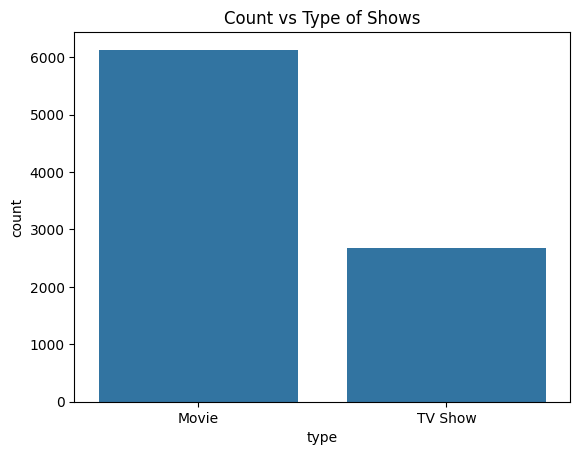

In [60]:
# countplot helps us to plot counts of each category
sns.countplot(x = 'type', data = df)
plt.title('Count vs Type of Shows')

It's quite evident from the plot graph, that on Netflix, there are more number of movies as compared to TV shows.

### Country Analysis

In [62]:
df['country'].value_counts().head(10) # will show us the countries along with their content production count on                                        netflix

country
United States     2818
India              972
Unavailable        831
United Kingdom     419
Japan              245
South Korea        199
Canada             181
Spain              145
France             124
Mexico             110
Name: count, dtype: int64

Text(0.5, 1.0, 'Country Wise Content on Netflix')

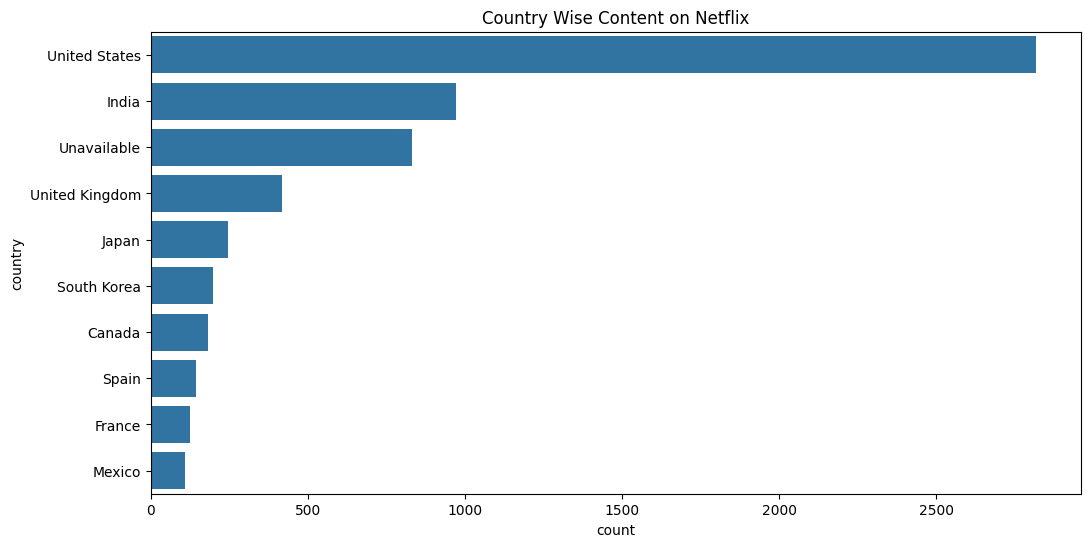

In [66]:
plt.figure(figsize=(12,6))
sns.countplot(y='country', order = df['country'].value_counts().index[0:10],data = df)
plt.title('Country Wise Content on Netflix')

Clearly, United States produces the most content on Netflix.

In [ ]:
# now checking the type of content production based on country
movie_countries = df[df['type'] == 'Movie']
tv_show_countries = df[df['type'] == 'TV Show']

Text(0.5, 1.0, 'Top 10 countries producing TV Shows in Netflix')

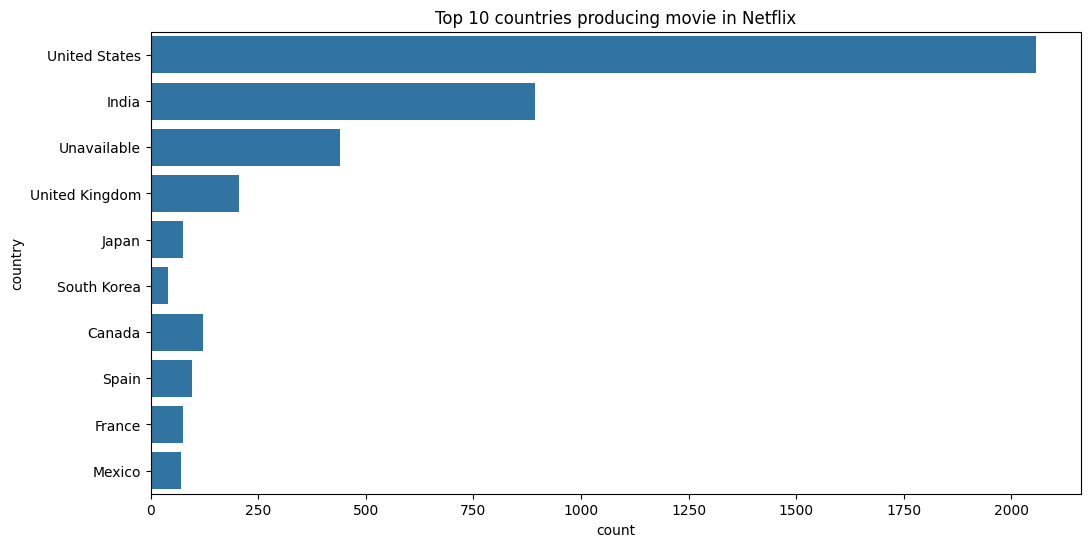

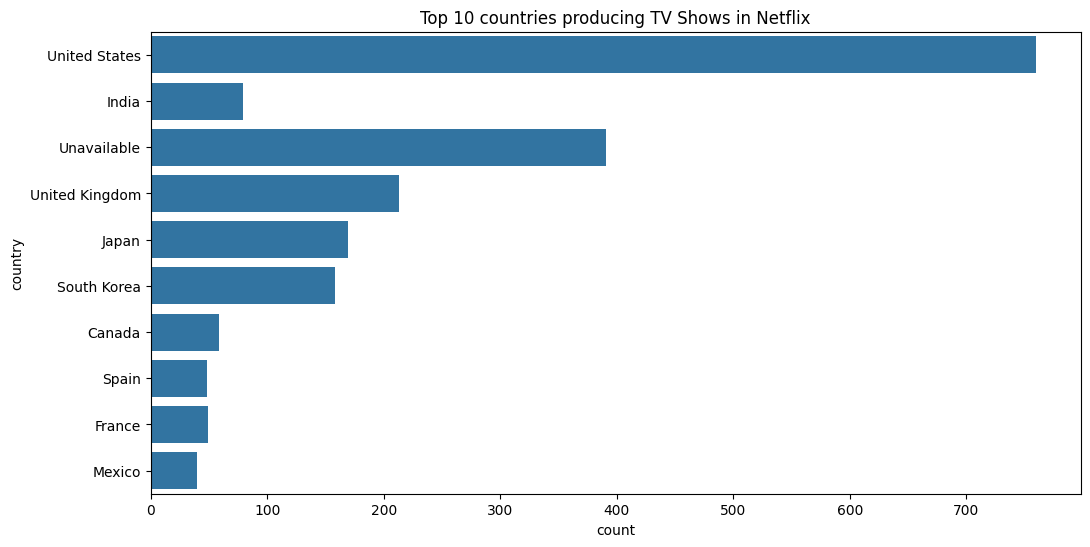

In [69]:
plt.figure(figsize=(12,6))
sns.countplot(y = 'country', order = df['country'].value_counts().index[0:10], data = movie_countries)
plt.title('Top 10 countries producing movie in Netflix')

plt.figure(figsize=(12,6))
sns.countplot(y = 'country', order = df['country'].value_counts().index[0:10], data = tv_show_countries)
plt.title('Top 10 countries producing TV Shows in Netflix')

Let's check what are the major ratings given to the Netflix Shows.

In [71]:
df.rating.value_counts()

rating
TV-MA          3207
TV-14          2160
TV-PG           863
R               799
PG-13           490
TV-Y7           334
TV-Y            307
PG              287
TV-G            220
NR               80
G                41
Unavailable       7
TV-Y7-FV          6
NC-17             3
UR                3
Name: count, dtype: int64

Text(0.5, 1.0, 'Ratings of shows on Netflix Vs Count')

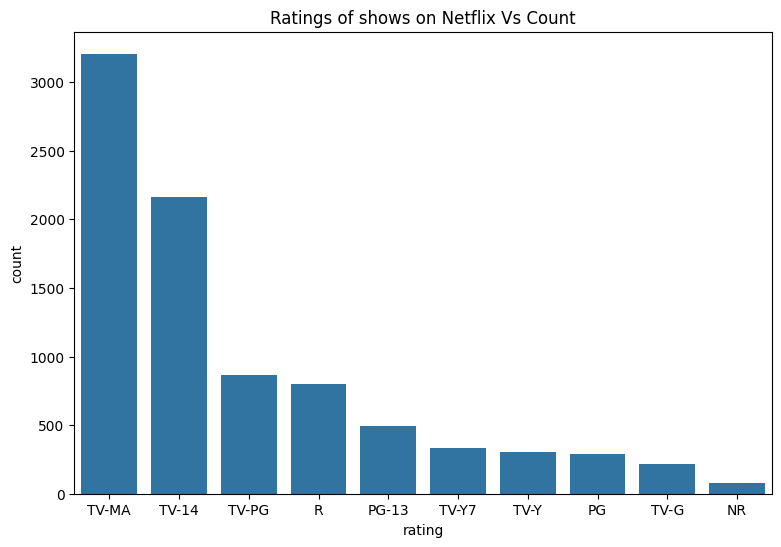

In [73]:
plt.figure(figsize = (9,6))
sns.countplot(x = 'rating', order = df['rating'].value_counts().index[0:10], data = df)
plt.title('Ratings of shows on Netflix Vs Count')

Most of the Shows has TV-MA and TV-14 ratings.

In [82]:
df.release_year.value_counts()[:20] # to find out in which year, the maximum number of contents had been produced

release_year
2018    1147
2017    1032
2019    1030
2020     953
2016     902
2021     592
2015     560
2014     352
2013     288
2012     237
2010     194
2011     185
2009     152
2008     136
2006      96
2007      88
2005      80
2004      64
2003      61
2002      51
Name: count, dtype: int64

Text(0.5, 1.0, 'Content Released in years on Netflix Vs Count ')

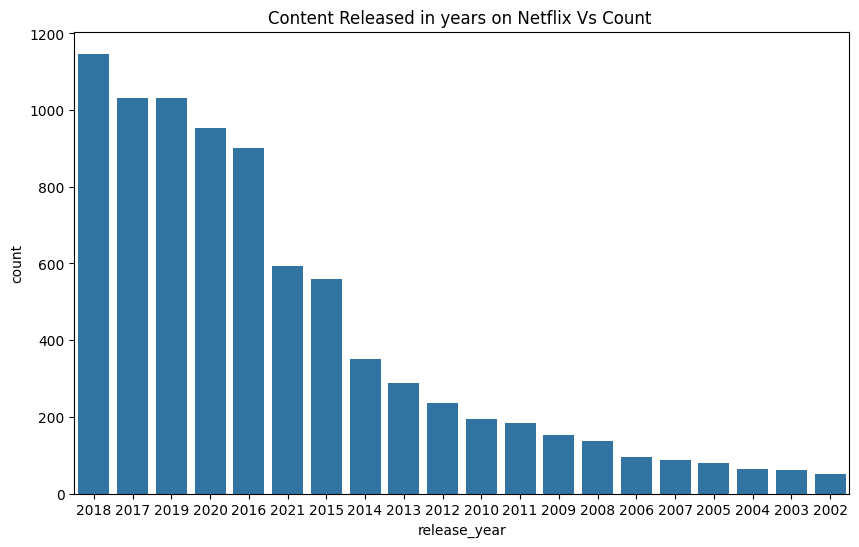

In [85]:
plt.figure(figsize = (10,6))
sns.countplot(x = 'release_year', order = df['release_year'].value_counts().index[0:20], data = df)
plt.title('Content Released in years on Netflix Vs Count ')

### Popular Genre Analysis

Text(0.5, 1.0, 'Top 20 Genres on Netflix')

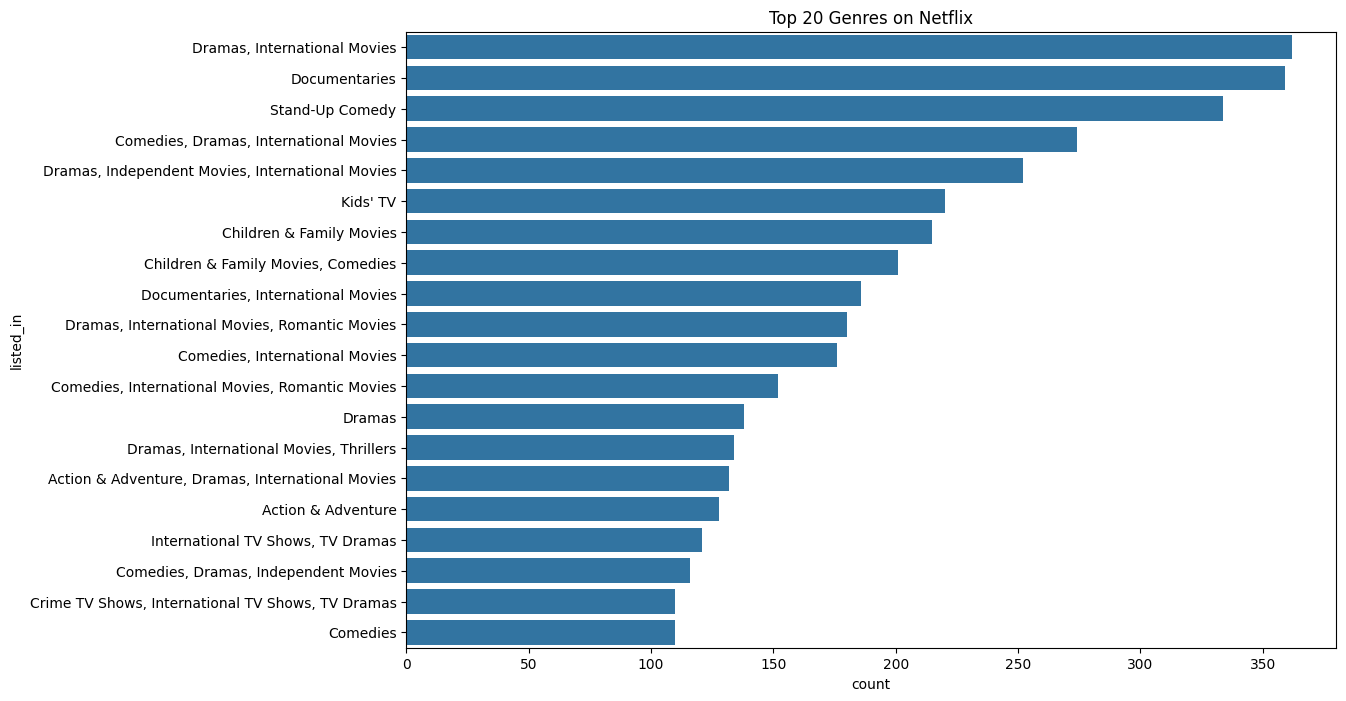

In [87]:
plt.figure(figsize = (12,8))
sns.countplot(y = 'listed_in' , order = df['listed_in'].value_counts().index[0:20], data = df)
plt.title('Top 20 Genres on Netflix')

### Summary

### Summary

So far we have performed a lot of operations over the dataset to gig out some very useful information from it.
Now, if we have to conclude the dataset in few lines, then we can say that:
*     Netflix has produced more Movies than TV Shows.
*     Most number of Movies and TV Shows have been produced by United States, followed by India who has produced the second       most number of movies anad TV Shows on Netflix.
*     Most of the content on Netflix( Movies and TV Shows combined ) is for Mature Audiences.
*     2018 was the year in which Netflix had produced the most number of contents compared to any other year.
*     International Movies and Dramas are the most popular Genres on Netflix.

In [91]:
df.to_csv('cleaned_netflix.csv', index=False)